# Student Information
**Name: Vishal Baraiya**  
**Enrollment No.: 23010101014**  
**Roll No.: C3-635**  
**Course:** Machine Learning & Deep Learning Project  

---

# **Objectives**

- Load cleaned data from Week 2
- Split into train and test sets
- Train Random Forest model
- Evaluate using accuracy and other metrics
- Plot confusion matrix and ROC curve
- Save model for deployment

# **1. Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

# **2. Load Dataset**

In [2]:
df = pd.read_csv("../data/processed/clean_cardio.csv")
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,smoke_age,smoke_bmi,alco_age,alco_bmi
0,18393,2,168,62.0,-0.998967,-0.138532,1,1,0,0,1,0,-0.434432,-1.049195,-0.307789,-0.305428,-0.235412,-0.233151
1,20228,1,156,85.0,0.797881,0.919885,3,1,0,0,1,1,0.309059,1.432867,-0.307789,-0.305428,-0.235412,-0.233151
2,18857,1,165,64.0,0.198932,-1.196948,3,1,0,0,0,1,-0.246432,-0.754140,-0.307789,-0.305428,-0.235412,-0.233151
3,17623,2,169,82.0,1.396830,1.978301,1,1,0,0,1,1,-0.746415,0.242218,-0.307789,-0.305428,-0.235412,-0.233151
4,17474,1,156,56.0,-1.597916,-2.255364,1,1,0,0,0,0,-0.806786,-0.849249,-0.307789,-0.305428,-0.235412,-0.233151


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68556 entries, 0 to 68555
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68556 non-null  int64  
 1   gender       68556 non-null  int64  
 2   height       68556 non-null  int64  
 3   weight       68556 non-null  float64
 4   ap_hi        68556 non-null  float64
 5   ap_lo        68556 non-null  float64
 6   cholesterol  68556 non-null  int64  
 7   gluc         68556 non-null  int64  
 8   smoke        68556 non-null  int64  
 9   alco         68556 non-null  int64  
 10  active       68556 non-null  int64  
 11  cardio       68556 non-null  int64  
 12  age_years    68556 non-null  float64
 13  bmi          68556 non-null  float64
 14  smoke_age    68556 non-null  float64
 15  smoke_bmi    68556 non-null  float64
 16  alco_age     68556 non-null  float64
 17  alco_bmi     68556 non-null  float64
dtypes: float64(9), int64(9)
memory usage: 9.4 MB


# **3. Define Features & Target**

In [4]:
feature_cols = [
    'age_years', 'ap_hi', 'ap_lo', 'bmi',
    'cholesterol', 'gluc',
    'smoke', 'alco', 'active',
    'smoke_age', 'smoke_bmi',
    'alco_age', 'alco_bmi'
]

X = df[feature_cols].values
y = df['cardio'].values

X.shape, y.shape

((68556, 13), (68556,))

# **4. Split Dataset**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((54844, 13), (13712, 13))

# **5. Train Random Forest Model**

In [6]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# **6. Make Predictions**

In [7]:
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# **7. Evaluate Model**

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.7055863477246208
Precision: 0.7070524412296564
Recall: 0.6915254237288135
F1 Score: 0.6992027419715371


## 7.1 Cross-validation & Hyperparameter Search
Run stratified 5-fold CV to get a baseline accuracy and then tune `RandomForestClassifier` hyperparameters. Evaluate the tuned model on the held-out test split.

In [9]:
# Stratified 5-fold CV accuracy for a baseline RandomForestClassifier
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_base = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(rf_base, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"CV accuracy: {cv_scores.mean():.3f} +/- {cv_scores.std():.3f}")

# Hyperparameter search over key RF settings
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0
)
search.fit(X, y)

best_rf = search.best_estimator_
print("Best params:", search.best_params_)
print(f"Best CV accuracy: {search.best_score_:.3f}")

# Evaluate the tuned model on the held-out test split
best_test_pred = best_rf.predict(X_test)
print("Test accuracy (best model):", accuracy_score(y_test, best_test_pred))

CV accuracy: 0.703 +/- 0.004
Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best CV accuracy: 0.734
Test accuracy (best model): 0.7474474912485414


# **8. Confusion Matrix**

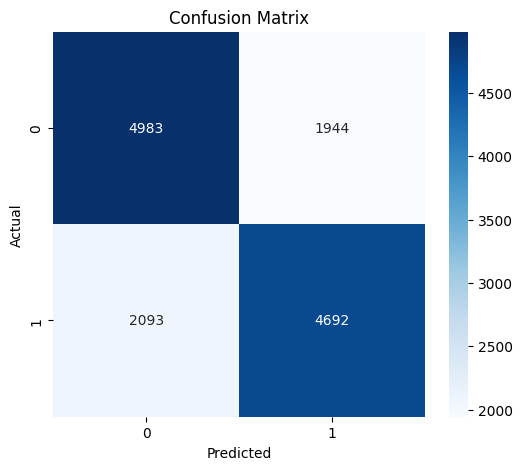

In [10]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **9. ROC Curve**

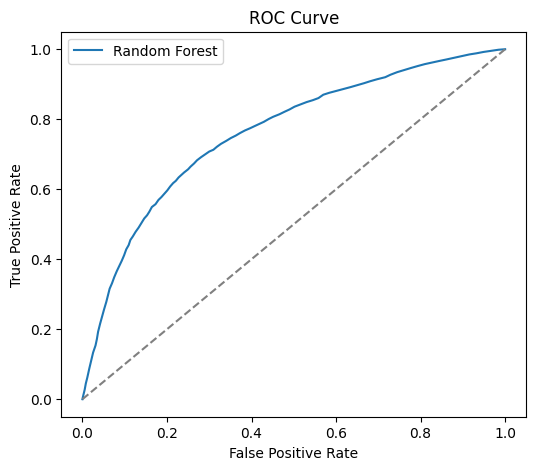

AUC Score: 0.7609687679888135


In [11]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print("AUC Score:", roc_auc_score(y_test, y_proba))

# **10. Feature Importance**

In [12]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance

,Feature,Importance
0,age_years,0.349950
3,bmi,0.293746
1,ap_hi,0.165162
2,ap_lo,0.081798
4,cholesterol,0.036870
5,gluc,0.014762
9,smoke_age,0.013899
10,smoke_bmi,0.013029
8,active,0.010020
11,alco_age,0.008530


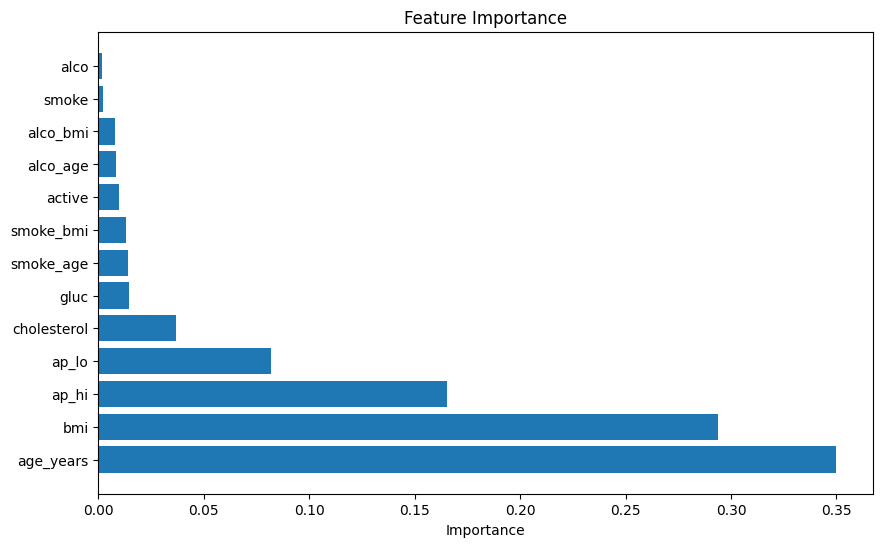

In [13]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

# **11. Save Model**

In [14]:
import pickle
import os

In [15]:
os.makedirs("../models", exist_ok=True)

with open('../models/random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)
    
print("Model saved successfully!")

Model saved successfully!


# **Week 3 Completed**
* Loaded cleaned dataset
* Split data into train and test
* Trained Random Forest model with 100 trees
* Evaluated using accuracy, precision, recall, F1 score
* Plotted confusion matrix and ROC curve
* Analyzed feature importance
* Saved model for deployment

---

## **Final Model Results (Random Forest)**

- **CV accuracy:** 0.703 ± 0.004
- **Best params:** {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
- **Best CV accuracy:** 0.734
- **Test accuracy (best model):** 0.7474474912485414

### **Feature Importances**
| Feature        | Importance |
|---------------|------------|
| age_years     | 0.349950   |
| bmi           | 0.293746   |
| ap_hi         | 0.165162   |
| ap_lo         | 0.081798   |
| cholesterol   | 0.036870   |
| gluc          | 0.014762   |
| smoke_age     | 0.013899   |
| smoke_bmi     | 0.013029   |
| active        | 0.010020   |
| alco_age      | 0.008530   |
| alco_bmi      | 0.008111   |
| smoke         | 0.002129   |
| alco          | 0.001995   |
